* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import imgaug
import numpy as np
import os
import pandas as pd
import time
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from tqdm.notebook import tqdm


#image augmentation:
import PIL
from PIL import Image
from imgaug import augmenters as iaa
import imgaug.augmenters as augs

In [8]:
### JAMIN'S SYSTEM ###

# These paths are hardcoded for my system, change as needed.

image_size = 96
tokens_dataset_folder = f'b=96_train=2011,2013_test=2012_c=all_t=2'

prefix = os.path.join(os.getcwd(), 'data', 'tokens', tokens_dataset_folder)

train_paths = [os.path.join(prefix, 'train', 'train.pickle')]
test_paths = [os.path.join(prefix, 'test', 'test.pickle')]
classes_path = os.path.join(prefix, 'classes.txt')

In [ ]:
### JESSE'S SYSTEM ###
image_size = 96
tokens_dataset_folder = f'b={image_size}_d=2011,2012,2013_c=all_t=5'

prefix = os.path.join(os.getcwd().strip("10617_Project'"), "CROHME_extractor", "outputs", tokens_dataset_folder)

train_path = os.path.join(prefix, 'train', 'train.pickle')
test_path = os.path.join(prefix, 'test', 'test.pickle')
classes_path = os.path.join(prefix, 'classes.txt')

In [ ]:
### GOOGLE COLAB IMPLEMENTATION ###
### Upload folder called "outputs" which contains the data into the Colab Notebooks folder in Drive. ###
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
image_size = 96
tokens_dataset_folder = f'b={image_size}_d=2011,2012,2013_c=all_t=5'

#path to where data folder is located in drive:

prefix = "/content/drive/My Drive/Colab Notebooks/outputs/" +  tokens_dataset_folder

train_path = prefix + '/train/train.pickle'
test_path = prefix + '/test/test.pickle'
classes_path = prefix + '/classes.txt'
print(train_path)

In [4]:
def encode_ohe(class_name, classes):
    one_hot = np.zeros(shape=(len(classes)), dtype=np.int8)
    class_index = classes.index(class_name)
    one_hot[class_index] = 1

    return one_hot

def decode_ohe(one_hot, classes):
    index = one_hot.argmax()
    return classes[index]

After unpickling, `train_set` and `test_set` will be lists, where each element is a dictionary that has keys `features` and `labels`. `features` will be a 1D numpy array of 1's and 0's, with size `box_size * box_size` where `box_size` is the size of the image. `label` will be a one-hot-encoded array.

### Data Augmentation
(source: https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll)

#### Pytorch built in library in torchvision:

* pros: relatively easy to use (have to convert to Pil image first but can just use np.array to convert back)
* cons: most are "random" so cannot know if image is same or different (do we want to feed in same image twice?)


In [ ]:
#contains the transforms we want to do:

#trans 1: rotate
rotate  = torchvision.transforms.Compose([   
                                             torchvision.transforms.ToPILImage(),
                                             torchvision.transforms.RandomRotation(15, resample=PIL.Image.BILINEAR, fill = 1),
])

#trans 2: pad image
pad  = torchvision.transforms.Compose([
                                             torchvision.transforms.ToPILImage(),
                                             torchvision.transforms.Pad(5, fill = 1)
                                       
])

transforms_list = [rotate, pad]


#  torchvision.transforms.RandomHorizontalFlip(),
#  torchvision.transforms.functional.affine(angle = 10)

In [ ]:
#for one example, check the output (jsut used first image as sample)

sample = train_set[1]["features"].reshape(96,96) #need to reshape to 2D 

print(sample.sum()) #see how many pixels originally 

for i, trans in enumerate(transforms_list):
    pic = trans(sample)
    print(np.array(pic).sum())
    print(np.array(pic).shape)
    plt.figure(figsize = (5,5))
    plt.imshow(pic, cmap='gray')
    plt.show()




#### ImageAug library 
* pros: more customizable while already having common functions pre-written, can also specify probability (which pytorch you cannot). Also can use numpy and not convert to Pil images
* cons: does not work with tensors I believe (so would have to come before image batching... not really a con). More work to implement (bc more customizable)

Note:
decided that flipping doesn't make sense (we shouldn't see upside down or backwards equations). Also, cannot crop too much for individual tokens else can lose part of symbol since already tokenized into smaller square (if sequence might be OK). Blur doesn't really work since 0s and 1s only.

In [ ]:
%%time

#there's a better way to do this... just get all features and reshape.
train_arrays = []
train_labels = []
for i in range(len(train_set)):
  #to keep the order!
  train_arrays.append(train_set[i]["features"])
  train_labels.append(train_set[i]["label"])

# train_set[1]["features"].shape

In [ ]:
### TRANSFORMATIONS ###
#crop
crop_0_16 = iaa.Crop(px=(0,5))
crop_16_0 = iaa.Crop(px=(5,0))

# #flipping:
# flip_lr = iaa.flip.Fliplr(1.0) #LEFT RIGHT
# flip_ud = iaa.flip.Flipud(1.0) #up and down

#convolutional matrices:

#blur
# matrix1 = np.array([[1,1,1], [0,1,0], [0,1,0]])
# filter_1 = imgaug.augmenters.convolutional.Convolve(matrix = matrix1)

#dropout sampling
sampler = iaa.Dropout(p=0.02)

#rotate forward and back
rotate_forward = iaa.Affine(rotate=10, mode = "constant", cval=0)
rotate_back = iaa.Affine(rotate=-10, mode = "constant", cval=0)
rotate_forward_extreme = iaa.Affine(rotate=20, mode = "constant", cval=0)
rotate_back_extreme = iaa.Affine(rotate=-20, mode = "constant", cval=0)

#move image:
translate_0 = iaa.Affine(translate_px={"x" : (-5), "y": (-5)},  cval=0)
translate_1 = iaa.Affine(translate_px={"x" : (5), "y": (5)},  cval=0)
translate_2 = iaa.Affine(translate_px={"x" : (0), "y": (5)},  cval=0)
translate_3 = iaa.Affine(translate_px={"x" : (5), "y": (0)},  cval=0)

#scale:
scale_small = iaa.Affine(scale={"x": (0.75), "y": (0.75)})
scale_squish = iaa.Affine(scale={"x": (1), "y": (0.75)})
scale_squeeze = iaa.Affine(scale={"x": (0.75), "y": (1)})

#shear:
shear_right = iaa.Affine(shear=(10))
shear_left = iaa.Affine(shear=(-10))

# scale_big = iaa.Affine(scale={"x": (1.), "y": (1.15)})


transformations = [crop_0_16, crop_16_0, sampler, rotate_forward, rotate_back,  rotate_forward_extreme, rotate_back_extreme, translate_0, translate_1,translate_2, translate_3, scale_small, scale_squish, scale_squeeze, shear_right, shear_left] #, scale_big, flip_lr, flip_ud,  
transformations_names = "crop_0_16, crop_16_0, sampler, rotate_forward, rotate_back, rotate_forward_extreme, rotate_back_extreme, translate_0, translate_1, translate_2, translate_3, scale_small, scale_squish, scale_squeeze, shear_right, shear_left".split(", ")

transformations_names
### EXAMPLE ###
#one sample:
# samples = 1 -  train_set[0]["features"]

#visualize:
# plt.figure(figsize = (5,5))
# plt.imshow(pic.reshape(96,96), cmap='gray')

#turn back into black and white:
# plt.figure(figsize = (5,5))
# plt.imshow(1 - pic.reshape(96,96), cmap='gray')





In [ ]:
#create transformed pickle files

train_tensor = np.array(train_arrays).reshape(-1, 96,96)
samples = 1 - train_tensor

for trans, name in zip(transformations, transformations_names):
  #apply transformations:
  pic = trans(images=samples)
  #turn back into white and black images
  reverted = 1 - pic
  #change shape
  tensored_transforms = reverted.reshape(-1, 96 * 96)

  #turn into series of transformed values
  trans_series = pd.Series(list(tensored_transforms))
  #turn into dataframe
  trans_df = pd.DataFrame({"features": trans_series, "numerical_label": train_labels})
  #OHE labels again
  ohes = np.zeros((len(trans_df["numerical_label"]), len(classes)))
  ohes[np.arange(len(ohes)), trans_df["numerical_label"]] = 1
  #add to dictionary
  trans_df["label"] = list(ohes)
  #add in extra note about transformation:
  trans_df["transformation"] = name

  #dump to pickle:
  with open('train_transformed_' + name + '.pkl', 'wb') as handle:
    pickle.dump(trans_df, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
#save pickles to drive
!cp /content/train_transformed_shear_right.pkl "/content/drive/My Drive/Colab Notebooks/Models"

!cp /content/train_transformed_translate_0.pkl "/content/drive/My Drive/Colab Notebooks/Models"

!cp /content/train_transformed_translate_1.pkl "/content/drive/My Drive/Colab Notebooks/Models"
!cp /content/train_transformed_translate_2.pkl "/content/drive/My Drive/Colab Notebooks/Models"
!cp /content/train_transformed_translate_3.pkl "/content/drive/My Drive/Colab Notebooks/Models"


### testing to ensure pickled outputs are like train pickles

In [ ]:
pickle_file = train_path
with open(pickle_file, 'rb') as f:
    df_data = pd.DataFrame(pickle.load(f))

pf = 'train_transformed_' + transformations_names[0] + '.pkl'
with open(pf, 'rb') as f:
    trans_data = pd.DataFrame(pickle.load(f))

In [ ]:
n = 100
(np.equal(trans_data["label"].iloc[n], df_data["label"].iloc[n]) == False).sum()
pic1 = trans_data["features"].iloc[n]
pic2 = df_data["features"].iloc[n]
plt.figure(figsize = (5,5))
plt.imshow(pic1.reshape(96,96), cmap='gray')
plt.figure(figsize = (5,5))
plt.imshow(pic2.reshape(96,96), cmap='gray')

### Generating Dataset 


In [5]:
class MathTokensDataset(Dataset):
    """
    Dataset containing math tokens extracted from the CROHME 2011, 2012, and 2013 datasets.
    """
    
    def __init__(self, pickle_files, image_size, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        pickles = []
        for p in pickle_files:
            with open(p, 'rb') as f:
                pickles.append(pickle.load(f))
                
        self.df_data = pd.concat([pd.DataFrame(p) for p in pickles], ignore_index=True)
        
        # Reshape features to 3D tensor.
        self.df_data['features'] = self.df_data['features'].apply(lambda vec: vec.reshape(1, image_size, image_size))
        
        # Convert one-hot labels to numbers (PyTorch expects this).
        self.df_data['label'] = self.df_data['label'].apply(lambda ohe_vec: np.argmax(ohe_vec))

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'features': self.df_data.iloc[idx]['features'],
            'label': self.df_data.iloc[idx]['label']
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class BaselineTokenCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineTokenCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=7)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 9 * 9, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, num_classes)
        
    def forward(self, x):
        x = x.float()
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
%%time
train_set = MathTokensDataset(train_paths, image_size)
test_set = MathTokensDataset(test_paths, image_size)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=0)

classes = np.array(open(classes_path, 'r').read().split())

Wall time: 893 ms


In [10]:
print(f'{len(train_set)} training examples.')
print(f'{len(test_set)} test examples.')
print(f'{len(classes)} classes.')

61892 training examples.
1887 test examples.
101 classes.


In [11]:
# Set device to GPU if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##### Mods:
1. Changing Optimizers
2. Changing NN structure
3. ???


In [12]:
#### 1. Optimizers to try: ###
#we can add more but just wanted to see

optimizer_dict = {"adam": optim.Adam,
                  "sgd": optim.SGD,
                  "adamW": optim.AdamW}

optimizer_params_dict = {"adam": {"lr": 0.001,
                             "weight_decay": 0},
                    "sgd": {"lr": 0.001, 
                            "momentum": 0.9},
                    "adamW": {"lr": 0.001,
                    "weight_decay": 0.01 }}


In [25]:
class Experiment():
    def __init__(self, experiment_name, optimizer_class):
        #get runtime:
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #get name for save files:
        self.experiment_name = experiment_name

        #make CNN
        self.net = BaselineTokenCNN(num_classes=len(classes))
        self.net.to(device)  # Send to GPU.

        #make loss
        self.criterion = nn.CrossEntropyLoss()

        #get optimizer and params:
        optimizer = optimizer_dict[optimizer_class]
        optimizer_params = optimizer_params_dict[optimizer_class]
        #add in the parameters:
        optimizer_params["params"] = self.net.parameters()
        # print(optimizer_params)

        #add in parameters to optimizer:
        self.optimizer = optimizer([optimizer_params])

        #keep track of train_history
        self.train_loss_history = []
        print("Model created with optimizer {}".format(optimizer_class))

    def train_network(self, n_epochs, train_loader):
        self.num_epochs = n_epochs

        for epoch in tqdm(range(self.num_epochs), position=1):
            
            running_loss = 0.0
            for i, data in tqdm(enumerate(train_loader), total=len(train_loader), position=0):
                # Get the inputs and send to GPU if available.
                features = data['features'].to(self.device)
                labels = data['label'].to(self.device)

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(features)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # save statistics
                
                self.train_loss_history.append(loss.item())
        print('Finished Training')

    def train_loss(self):

        loss = np.mean(self.train_loss_history)
        print(f"Loss of the network on train set: {loss}")
        return loss

        
    def test_accuracy(self, classes, test_loader):
      
        self.num_classes = len(classes)

        self.total_counts = np.zeros(self.num_classes)
        self.correct_counts = np.zeros(self.num_classes)
        self.predictions = []
        # print(total_counts)
        # print(correct_counts)

        self.num_correct = 0
        self.num_total_examples = 0

        with torch.no_grad():
            for test_data in tqdm(test_loader):
                test_features = test_data['features'].to(self.device)
                labels = test_data['label'].to(self.device)
                
                outputs = self.net(test_features)
                
                _, predicted = torch.max(outputs.data, dim=1)
                self.predictions.append(predicted)
                
                for p, l in zip(labels, predicted):
                    self.total_counts[l] += 1
                    if p == l:
                        self.correct_counts[p] += 1
                
                self.num_total_examples += labels.size(0)
                self.num_correct += (predicted == labels).sum().item()
            self.test_accuracy = self.num_correct / self.num_total_examples * 100
        print(f'Accuracy of the network on test set: {self.test_accuracy}%')


    def save_checkpoint(self,path):
        #save the model at a certain checkpoint
        values_to_save = {
            'epoch': self.num_epochs,
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': np.mean(self.train_loss_history),
            }

        #if test data, also save, else keep same:
        try: 
            values_to_save["test_accuracy"] = self.test_accuracy
        except:
            pass

        torch.save(values_to_save, path + self.experiment_name)
        print("Checkpoint successfully saved!")
        
    def save_model(self,path):
        torch.save(self.net.save_model, path + self.experiment_name)
        print("Model successfully saved!")


In [28]:
### EXPERIMENT 1:
exp1 = Experiment("Jamin_CNN_adamW", "adamW")
exp1.train_network(n_epochs=15, train_loader=train_loader)
exp1.test_accuracy(classes=classes, test_loader=test_loader)
exp1.train_loss()

save_path_jesse = "/content/drive/My Drive/Colab Notebooks/Models/"
save_path_jamin = os.path.join(os.getcwd(), 'data', 'models')

save_path = save_path_jamin

exp1.save_checkpoint(save_path)

Model created with optimizer adamW




Finished Training



Accuracy of the network on test set: 81.92898781134075%
Loss of the network on train set: 0.30951576750140547
Checkpoint successfully saved!


### Reviewing Results

In [ ]:
test_data_iter = iter(test_loader)
data = test_data_iter.next()

test_features = data['features'].to(device)
labels = data['label'].to(device)

outputs = exp1.net(test_features)

# Tbh I'm not sure why it's max here and not argmax.
_, predicted = torch.max(outputs.data, dim=1)

for f, l, p, in zip(test_features, labels, predicted):
    f = np.squeeze(f.cpu().numpy())
    # plt.figure()
    # plt.imshow(f, cmap='gray')
    # plt.show()
    print(f'Predicted = {classes[p]}, Actual = {classes[l]}')

In [ ]:
#get test data:
with open(test_path, 'rb') as f:
    test_df = pd.DataFrame(pickle.load(f))

#convert over to labels and predictions to use in confusion matrix
test_df['class_label'] = test_df['label'].apply(lambda ohe_vec: np.argmax(ohe_vec))
test_df["prediction"] = torch.cat(exp1.predictions).cpu().numpy()

test_df["class_symbol"] = test_df["class_label"].apply(lambda x: classes[x])
test_df["prediction_symbol"] = test_df["prediction"].apply(lambda x: classes[x])

In [ ]:
#matches where pred == actual value
test_df["match"] = test_df["prediction"] == test_df["class_label"]
#get matches per class
matches_per_class = test_df[test_df["match"] == True]["class_symbol"].value_counts()
#get percent accuracy:
class_accuracy = matches_per_class / test_df["class_symbol"].value_counts()
class_accuracy

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#make confusion matrix to see where messing up:
cm = confusion_matrix(test_df["class_symbol"], test_df["prediction_symbol"], labels = classes, normalize="true")
#note, should probably make sure the order is correct, but put classes as labels... so should be.
confusion_df = pd.DataFrame(cm, index = classes, columns = classes)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
plt.figure(figsize = (15,12))
sns.heatmap(confusion_df, cmap="hot")

In [ ]:
total_counts_idx = np.argsort(exp1.total_counts)
total_counts_idx = total_counts_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_counts_idx], exp1.total_counts[total_counts_idx])
plt.title('Token Counts')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()

In [ ]:
total_acc = correct_counts / total_counts

total_acc_idx = np.argsort(total_acc)
# total_acc_idx = total_acc_idx.astype(int)

plt.figure(figsize=(6,18), dpi=600)
plt.barh(classes[total_acc_idx], total_acc[total_acc_idx])
plt.title('Token Accuracies')
plt.xticks(rotation=90)
plt.margins(y=0.005)
plt.show()

# Identifying Expressions

In [30]:
import cv2

cv2.startWindowThread()

class ExpressionImageDataset(Dataset):
    """
    An expression-level dataset.
    """
    def __init__(self, pickle_file, transform=None):
        """
        Args:
            pickle_file (string): Path to dataset pickle file.
            transform (callable, optional): Optional transform to be applied
                    on a sample.
        """
        with open(pickle_file, 'rb') as f:
            self.df_data = pd.DataFrame(pickle.load(f))
            
#         print(self.df_data)

        self.transform = transform
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        row = self.df_data.iloc[idx]
                
        traces_data = row['traces_data']
        img_path = row['img_path']
        tokens = row['tokens']
        latex = row['latex']
        
        # CV2 will read the image with white being 255 and black being 0, but since
        # our token-level training set uses binary arrays to represent images, we
        # need to binarize our image here as well.
        image_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image_binarized = cv2.threshold(image_raw, 127, 255, cv2.THRESH_BINARY)[1]
        image_bitmap = image_binarized / 255.0
        
        sample = {
            'image': image_binarized,
            'image_bitmap': image_bitmap,
            'traces_data': traces_data,
            'tokens': tokens,
            'latex': latex
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample

In [38]:
train_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'train', 'train.pickle')
test_exp_path = os.path.join(os.getcwd(), 'data', 'train=2011,2013_test=2012', 'test', 'test.pickle')

# print('train')
train_exp_set = ExpressionImageDataset(train_exp_path)
# print('test')
test_exp_set = ExpressionImageDataset(test_exp_path)

In [32]:
def image_to_components(img):
    """
    Identifies the connected components (groups of black pixels) within an image.
    Returns a list of tuples. The first element of each tuple is the component
    image, and the second element is a tuple representing the bounding box of the
    component (relative to the original image dimensions).
    """
    
    # Invert the image because for CV2, foreground objects should be white, and the background black.
    img_flipped = cv2.bitwise_not(img)

    # cv2.connectedComponents returns a mask of the input where each element is a number from 0
    # to num_labels. All the 0's are considered the same component, 1's together, so on and
    # so forth.
    num_labels, labeled_img = cv2.connectedComponents(img_flipped)

    components = []

    # Skip the first component because it will be the background.
    for l in range(1, num_labels):
        mask = np.zeros(labeled_img.shape, dtype=np.uint8)
        mask[labeled_img == l] = 255

        rect = cv2.boundingRect(mask)

    #     # Draw bounding box to make sure it's correct.
    #     cv2.rectangle(mask, (x, y), (x + w, y + h), (36,255,12), 2)

        mask = cv2.bitwise_not(mask)

        components.append((mask, rect))

    components.sort(key=lambda c: (c[1][0], c[1][1]))

#     for mask, rect in components:    
#         plt.imshow(mask, cmap='gray')
#         plt.show()
        
    return components

In [33]:
def process_component(image, bounding_rect):
    """
    Processes a component image so it can be fed into the CNN for as input.
    It crops the component, pads the cropped image so that it's square, and
    then resizes it to the shape the CNN expects.
    
    Args:
        image - Image containing a single component.
        bounding_rect - Tuple defining the bounding box of the component.
    """
    
    x, y, w, h = bounding_rect
    
    # Crop the image to just the bounding box.
    image = image[y: y + h, x: x + w]
    
    # Pad the image so it's square.
    if w > h:
        pad = int((w - h) / 2)        
        image = cv2.copyMakeBorder(image, 
                                   top=pad, 
                                   bottom=pad, 
                                   left=0, 
                                   right=0, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    else:
        pad = int((h - w) / 2)
        image = cv2.copyMakeBorder(image, 
                                   top=0, 
                                   bottom=0, 
                                   left=pad, 
                                   right=pad, 
                                   borderType=cv2.BORDER_CONSTANT, 
                                   value=255)
    
    # Scale down to the correct size. Seems like cv2.INTER_AREA is the best
    # interpolation method for maintaining stroke wdith.
    image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)
    
    # During the resize some pixels will get scaled to be between 0 (black) and 255 (white).
    # In order to maintain stroke width, we set all non-white pixels to full black.
    # If we don't do this the resulting image ends up looking rather sparse.
    # We also convert the image to binary so that it's ready for the model.
    image = (image == 255).astype(int)
    
    return image

(322, 483)


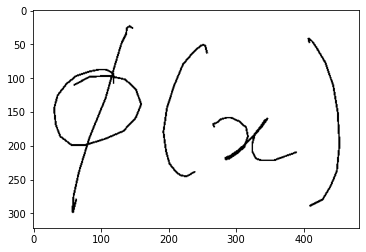

(30, 22, 131, 278)


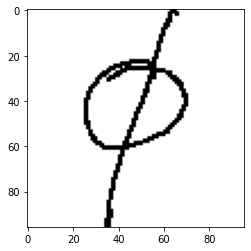

(191, 50, 68, 197)


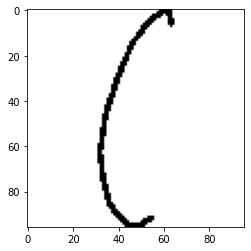

(265, 158, 125, 65)


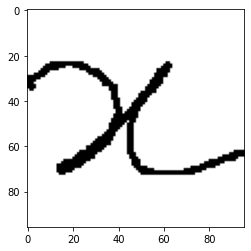

(405, 41, 49, 250)


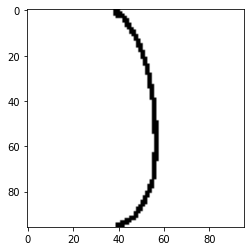

In [34]:
# Example code.
test_img = train_exp_set[0]['image']

print(test_img.shape)
plt.imshow(test_img, cmap='gray')
plt.show()

components = image_to_components(test_img)

for img, rect in components:
    print(rect)
    
    out = process_component(img, rect)
    plt.imshow(out, cmap='gray')
    plt.show()

# Testing Expression-Level Detection

In [35]:
test_traces_data = train_exp_set[2]['traces_data']

def get_traces_data_stats(traces_data):
    all_coords = []
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            all_coords.extend(trace)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height

def get_trace_group_bounding_box(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height
    

def draw_traces_data(traces_data):
    im_x_min, im_y_min, width, height = get_traces_data_stats(traces_data)
    
    # Scale the image down.
    max_dim = 1000 # Maximum dimension pre-pad.
    sf = 1000 / max(height, width)
    scaled_height = int(height * sf)
    scaled_width = int(width * sf)
    
    image = np.ones((scaled_height, scaled_width))
    
    # Draw the traces on the unscaled image.
    for pattern in traces_data:
        for trace in pattern['trace_group']:
            trace = np.array(trace)
            trace -= np.array([im_x_min, im_y_min])
            trace = (trace.astype(np.float64) * sf).astype(int)
            
            for coord_idx in range(1, len(trace)):
                cv2.line(image, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=5)
            
    # Pad the scaled image.
    pad_factor = 0.05
    pad_width = ((int(pad_factor * scaled_height), int(pad_factor * scaled_height)), 
                 (int(pad_factor * scaled_width), int(pad_factor * scaled_width)))
    image = np.pad(image, 
                     pad_width=pad_width, 
                     mode='constant', 
                     constant_values=1)
    
    # Binarize.
    image = (image > 0).astype(int) 
    
    # Open CV wants images to be between 0 and 255.
    image *= 255
    image = image.astype(np.uint8)
    
    boxes = []
    
    # Get bounding boxes.
    for pattern in traces_data:
        trace_group = pattern['trace_group']
        rect_x_min, rect_y_min, rect_width, rect_height = get_trace_group_bounding_box(trace_group)
        
        rect_x_min = (rect_x_min - im_x_min) * sf + pad_width[1][0]
        rect_y_min = (rect_y_min - im_y_min) * sf + pad_width[0][0]
        
        rect_width *= sf
        rect_height *= sf
        
        # Convert bounding box coords to integers.
        rect_x_min = int(rect_x_min)
        rect_y_min = int(rect_y_min)
        rect_width = int(rect_width)
        rect_height = int(rect_height)
              
        # Draw the rectangle.
#         image = cv2.rectangle(image, 
#                               (int(rect_x_min), int(rect_y_min)), 
#                               (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
#                               (0), 
#                               5)
        
        boxes.append((rect_x_min, rect_y_min, rect_width, rect_height))
    
#     plt.imshow(image, cmap='gray')
#     plt.show()
    
    return image, boxes
    
image, boxes = draw_traces_data(test_traces_data)
print(image.shape)
print(boxes)

(126, 1100)
[(50, 15, 6, 87), (75, 31, 57, 82), (192, 18, 9, 98), (465, 21, 11, 100), (514, 27, 44, 88), (590, 29, 48, 79), (877, 12, 49, 97), (967, 5, 82, 84), (281, 15, 92, 103), (690, 19, 115, 97)]


In [36]:
def intersect_area(rect1, rect2):
    """
    rect1 and rect2 are tuples of the form (x, y, width, height).
    """
    r1_x_min, r1_y_min, r1_width, r1_height = rect1
    r2_x_min, r2_y_min, r2_width, r2_height = rect2
    
    dx = min(r1_x_min + r1_width, r2_x_min + r2_width) - max(r1_x_min, r2_x_min)
    dy = min(r1_y_min + r1_height, r2_y_min + r2_height) - max(r1_y_min, r2_y_min)
    if (dx>=0) and (dy>=0):
        return dx*dy
    
    return 0
    
def get_iou(rect1, rect2):
    rect1_area = rect1[2] * rect1[3]
    rect2_area = rect2[2] * rect2[3]
    
    intersect = intersect_area(rect1, rect2)
    union = rect1_area + rect2_area - intersect
    
    return intersect / union

In [39]:
from collections import defaultdict

num_exp_correct = 0
num_tokens_wrong_dict = {}

all_precision = defaultdict(list)
all_recall = defaultdict(list)

# We evaluate on test_exp_set, which is generated only using data from 2012. This is to avoid data leakage
# with the token-level training set, which is generated on data from 2011 and 2013.
for data in tqdm(test_exp_set):
    image, true_boxes = draw_traces_data(data['traces_data'])
        
    # Get the components present in the image.
    components = image_to_components(image)
    
    # Generate 96x96 input images for each component.
    component_images_processed = [process_component(comp_img, comp_rect) for comp_img, comp_rect in components]
    
    # Construct CNN input tensor.
    features_numpy = np.array(component_images_processed)
    features_numpy = np.expand_dims(features_numpy, 1)
    features_tensor = torch.from_numpy(features_numpy).to(device)
            
    outputs = exp1.net(features_tensor)
    
    _, predicted = torch.max(outputs.data, dim=1)
    
    # For classification.
    predicted_tokens = classes[predicted.cpu()]
    actual_tokens = data['tokens']
    
#     print('actual_tokens:', actual_tokens)
    
    # For bounding box quality.
    predicted_boxes = [comp_rect for comp_img, comp_rect in components]
    
    # Calculate average precision at different iou thresholds.
    iou_thresholds = [0.05, 0.5, 0.80]
    
    for thresh in iou_thresholds:
        true_pos = 0
        false_pos = 0
        true_neg = 0
        false_neg = 0
        
        for true_box, true_token in zip(true_boxes, actual_tokens):
            for pred_box, pred_token in zip(predicted_boxes, predicted_tokens):
                iou = get_iou(true_box, pred_box)
                
                if iou >= thresh:
                    if pred_token == true_token:
                        true_pos += 1
                    else:
                        false_pos += 1
                        
        curr_precision = true_pos / (true_pos + false_pos) if true_pos + false_pos > 0 else 0
        curr_recall = true_pos / len(actual_tokens)
        
        all_precision[thresh].append(curr_precision)
        all_recall[thresh].append(curr_recall)
    
    # Calculate number of tokens predicted correctly.
    num_tokens_correct = 0
    for p, a in zip(predicted_tokens, actual_tokens):
        p = p.replace('\\', '')
        a = a.replace('\\', '')
        if p == a:
            num_tokens_correct += 1
            
    num_tokens_correct += np.max(len(actual_tokens) - len(predicted_tokens), 0)
    
    num_tokens_wrong = len(actual_tokens) - num_tokens_correct
    
    if num_tokens_wrong == 0:
        num_exp_correct += 1
        
    num_tokens_wrong_dict[num_tokens_wrong] = num_tokens_wrong_dict.get(num_tokens_wrong, 0) + 1
    
#     true_image = np.array(image, copy=True)
#     for box in true_boxes:
#         rect_x_min, rect_y_min, rect_width, rect_height = box
#         true_image = cv2.rectangle(true_image, 
#                       (int(rect_x_min), int(rect_y_min)), 
#                       (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
#                       (0), 
#                       5)
    
#     pred_image = np.array(image, copy=True)
#     for box in predicted_boxes:
#         rect_x_min, rect_y_min, rect_width, rect_height = box
#         pred_image = cv2.rectangle(pred_image, 
#                       (int(rect_x_min), int(rect_y_min)), 
#                       (int(rect_x_min + rect_width), int(rect_y_min + rect_height)), 
#                       (0), 
#                       5)
        
#     print('Image with true boxes:')
#     plt.imshow(true_image, cmap='gray')
#     plt.show()
    
#     print('Image with predicted boxes:')
#     plt.imshow(pred_image, cmap='gray')
#     plt.show()
    
#     for thresh in iou_thresholds:
#         print(f'Precision at {thresh}: {all_precision[thresh]}')
#         print(f'Recall at {thresh}: {all_recall[thresh]}')

In [40]:
for thresh in iou_thresholds:
    print(f'Average precision at {thresh}: {np.mean(all_precision[thresh])}')
    print(f'Average recall at {thresh}: {np.mean(all_recall[thresh])}')
    print()

Average precision at 0.05: 0.4952153629729873
Average recall at 0.05: 0.6145686740558548

Average precision at 0.5: 0.6469595689052171
Average recall at 0.5: 0.516713646531021

Average precision at 0.8: 0.7655843886225053
Average recall at 0.8: 0.3342254516738495



In [ ]:
num_exp_correct

# Scratch

Below is some code I wrote to play around with drawing the traces from scratch.

In [ ]:
import cv2
from skimage.transform import resize

In [ ]:
train_exp_set[0]

In [ ]:
trace = train_exp_set[0]['traces_data'][0]


def get_trace_group_stats(trace_group):
    all_coords = []
    for t in trace_group:
        all_coords.extend(t)
        
    all_coords = np.array(all_coords)
    
    x_min, y_min = np.min(all_coords, axis=0)
    width, height = np.max(all_coords, axis=0) - [x_min, y_min] + 1
    
    return x_min, y_min, width, height


def scale_trace_group(trace_group, image_size, width, height):
    scaling_factor = image_size / max(width, height)
    
    trace_group_scaled = [(trace * scaling_factor).astype(int) for trace in trace_group]
        
    return trace_group_scaled


def shift_trace_group(trace_group, x_min, y_min):
    trace_group_shifted = [trace - [x_min, y_min] for trace in trace_group]
    return trace_group_shifted


def draw_trace_group(trace_group, height, width, thickness):
    placeholder = np.ones((height, width))
        
    for trace in trace_group:
        for coord_idx in range(1, len(trace)):
            cv2.line(placeholder, tuple(trace[coord_idx - 1]), tuple(trace[coord_idx]), color=(0), thickness=thickness)
        
    return placeholder

    
def process_trace_group(trace_group, thickness=2):
    trace_group = [np.array(trace) for trace in trace_group]
    
    x_min, y_min, width, height = get_trace_group_stats(trace_group)
    
    trace_group = shift_trace_group(trace_group, x_min, y_min)
    trace_group = scale_trace_group(trace_group, image_size, width, height)
    
    im = draw_trace_group(trace_group, height=image_size, width=image_size, thickness=thickness)
    
#     new_im = cv2.copyMakeBorder(im, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=1)
    
#     im = cv2.resize(im, (image_size, image_size))
    
    
    
    plt.imshow(im, cmap='gray')
    
        
process_trace_group(trace['trace_group'])